# Analysis of the effect of ethnicity on food purchase in London

- Does ethnic diversity have an effect on food purchase at area level? And if yes, what is its nature?
- To which extent is the ethnic diversity responsible for the food purchase diversity of some aliment categories?
- Can we attribute particular food purchase habits to specific ethnic groups?

The objective is to extend the Tesco dataset with a dataset containing numerous interesting socio-economic statistics in the London area. The analysis focuses on LSOA regions, which is the finest resolution available in the Tesco dataset. The proportion of inhabitants from various ethnicities is given for each LSOA in the additional dataset. We will first analyze the effect of ethnic diversity on food purchase. It will be based on the comparison of diversity of food categories purchased across LSOA regions and their ethnic diversity. We will then try to validate the observations we made by assessing if they still hold when other socio-economic aspects (such as mean wage for example) are taken into account. Depending on the results found, we will also investigate in greater details what impact specific ethnic populations may have on the food purchase.

## Table of content 

## 1. Set the environment and perform exploratory analysis

### Import the packages 

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import plotly
import plotly.express as px
import scipy
from scipy.stats import spearmanr
import os
import re
from causal_curve import GPS

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

### Define the paths of the different datasets use for the analysis
Three main datasets are used for this project:
- **Tesco dataset**: besides the nutrients information used in the validation analysis of the paper, this dataset offers information on the purchases of different products at the area level. It's those information that will be used in our project at the LSOA level. 
- **Socio-economic dataset of the LSOA**: this dataset provides socio-economic information at the LSOA level. Combining this dataset with the Tesco one will allow us to put into perspective the ethnicity of the population with their food consumption. 
- **Geographical information dataset of the LSOA**: this dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

### Define some functions that will be used throughout the project
The roles of the functions define below are the following:
- `load_merge_clean_data()`: this function takes as input the paths of the three datasets used in this project. It will load those different datasets and process them to return one single dataset containing the information of the three datasets of interest.
- `plot_map()`: this function allows to display a feature on the London map with its values assigned to each geographical region representing the LSOA. It takes as input the dataframe considered (that should contain the geographical information) as well as the name of the feature to be plotted on the map, if this feature is part of the dataframe, OR the feature array can directly be given as an input as well. 

In [3]:
###############################################################################################################
#############################     Load merge and clean function      ##########################################
###############################################################################################################
def filter_and_clean_losa(lsoa_df):
    
    filtered_df = lsoa_df.copy()
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
    
    return filtered_df


def load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH):
    '''
    This function load the different datasets used for the analysis,
    clean and merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # load the data with the geography information of each LSOA
    map_df = gpd.read_file(GEO_LSOA_PATH)
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # load the data with the Tesco information of each LSOA
    data_df = pd.read_csv(TESCO_PATH)
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(data_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # load the data with the socio-economic information of each LSOA
    lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    lsoa_df.drop(lsoa_df.tail(2).index,inplace=True)
    # filter the lsoa dataset
    lsoa_df = filter_and_clean_losa(lsoa_df)
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower Super Output Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # remove spaces in column names
    merged_map_lsoa_df.columns = merged_map_lsoa_df.columns.str.replace(' ', '_')
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


###############################################################################################################
#####################################     Plot functions     ##################################################
###############################################################################################################

def plot_map(dataframe, name_feature, color = 'magma', opacity = 0.9):
    '''
    plot the feature of the dataframe on the London map
    '''
    fig = px.choropleth_mapbox(dataframe,
                               geojson=dataframe.geometry,
                               locations=dataframe.index,
                               color=name_feature,
                               center={"lat": 51.49, "lon": -0.127},
                               mapbox_style="carto-positron",
                               opacity = opacity,
                               color_continuous_scale = color, # https://plotly.com/python/colorscales/   
                               # magma, viridis
                               zoom=9)

    fig.update_layout(height = 500, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

### Create the dataframe with all the information of the three datasets of interest

In [4]:
full_df = load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH)
full_df.head(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.886,0.094,0.020,0.592,0.325,0.061,0.017,0.005,74846.0,58347.0
City of London 001B,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,0.899,0.074,0.027,0.580,0.353,0.046,0.016,0.006,73325.0,57159.0
City of London 001C,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,0.807,0.132,0.062,0.802,0.181,0.013,0.002,0.001,44130.0,34387.0
City of London 001E,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,0.794,0.133,0.073,0.762,0.214,0.019,0.004,0.000,30781.0,24000.0
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.861,0.097,0.042,0.343,0.459,0.160,0.026,0.013,46141.0,39141.0


## Computation of new features

In [5]:
def compute_entropies(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    if np.any(f_df > 1):
        f_df = f_df.div(f_df.sum(axis=1), axis=0)
        
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)

    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h'].values, h_df['h_norm'].values

To make a difference between food and drinks, in addition to the already present h_items, we compute two new category entropies taking only part of the items in consideration h_food and h_drink with their normalizer conterparts

In [6]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food, h_items_food_norm = compute_entropies(full_df, food_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_food', h_items_food.tolist(), True)

In [7]:
drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink, h_items_drink_norm = compute_entropies(full_df, drink_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('h_items') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)
full_df.insert(new_h_idx, 'h_items_drink', h_items_drink.tolist(), True)

We then compute an entropy of the diverse ethnic groups in each area to get a sense of the racial diversity of the area

For our entropy computation, we need the representation of each ethnic groups to be described as a probability between 0 and 1 instead of a percentage value, we will modify those columns accordingly in the dataframe

In [8]:
ethnicity_col_list = ['Ethnic_Group;White_(ratio);2011',
                      'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                      'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                      'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                      'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicity, h_ethnicity_norm = compute_entropies(full_df, ethnicity_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicity_norm.tolist(), True)
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities;2011', h_ethnicity.tolist(), True)

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Correlation analysis

To begin our analysis, we compute the correlations between the ethnicity and the product categories purchased at different level of granularity. We used Spearman rank correlation.

- Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm
- Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm
- Correlation between the different propotrions of ethnic groups and different propotrions of items category

## Correlation between h_ethnicity_norm and h_food_norm, h_drink_norm

In [9]:
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values

rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)

d = {'Category': ['food', 'drink'],
     'R': [rho_food, rho_drink],
     'p-value': [p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

,Category,R,p-value
0,food,0.286189,9.082810e-92
1,drink,0.192731,1.157947e-41


### Visualization

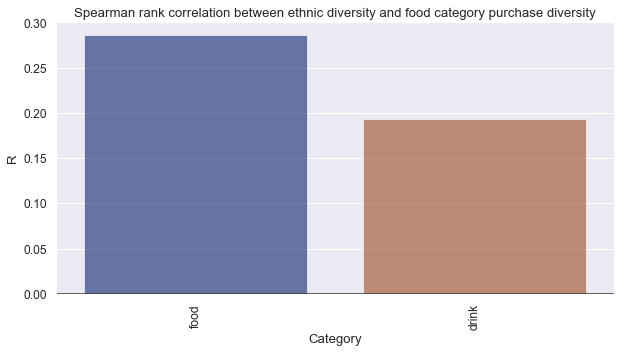

In [35]:
# keep only the significant data
hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < 0.05]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Category', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R')
plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity and food category purchase diversity')
plt.show()

## Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm

In [11]:
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)

# list containing the values of items entropy for food and drink
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values
h_item_categories = [h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Category': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

,Ethnicity,Category,R,p-value
0,Ethnic_Group;White_(ratio);2011,food,-0.148771,2.537757e-25
1,Ethnic_Group;White_(ratio);2011,drink,-0.155952,1.082312e-27
2,Ethnic_Group;Mixed/multiple_ethnic_groups_(rat...,food,0.310607,1.375516e-108
3,Ethnic_Group;Mixed/multiple_ethnic_groups_(rat...,drink,0.249160,2.676778e-69
4,Ethnic_Group;Asian/Asian_British_(ratio);2011,food,-0.053519,1.974140e-04
5,Ethnic_Group;Asian/Asian_British_(ratio);2011,drink,-0.078691,4.310637e-08
6,Ethnic_Group;Black/African/Caribbean/Black_Bri...,food,0.366747,9.108755e-154
7,Ethnic_Group;Black/African/Caribbean/Black_Bri...,drink,0.362461,5.570965e-150
8,Ethnic_Group;Other_ethnic_group_(ratio);2011,food,0.132814,1.828360e-20
9,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,-0.036551,1.104659e-02


### Visualization

<Figure size 720x360 with 0 Axes>

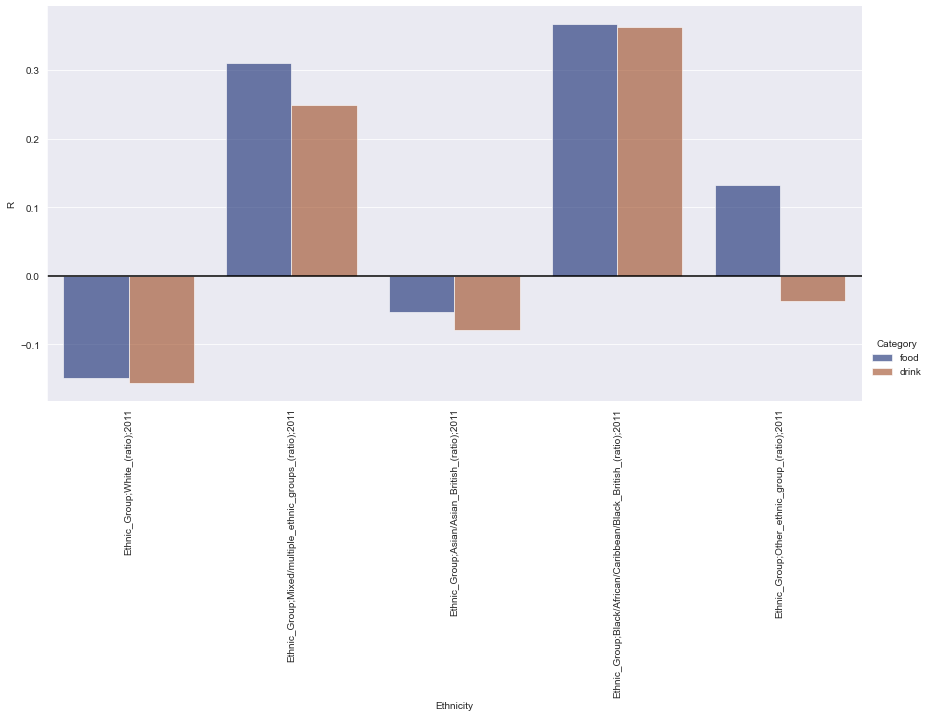

In [13]:
# keep only the significant data 
fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < 0.05]

sns.set_style("dark")

plt.figure(figsize=(10,5))
g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnicity", y="R", hue="Category", palette="dark", alpha=.6, height=6, aspect=2)
for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')
plt.xticks(rotation=90 )
plt.show()

## Correlation between the different proportions of ethnic groups and different proportions of items category

In [14]:
# list containing names of the different products proportions
f_items_idx_lo = full_df.columns.get_loc('f_beer') 
f_items_idx_hi = full_df.columns.get_loc('f_wine')+1
item_col = np.array(full_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)


f_items = []
for col in full_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(full_df[col].values)

f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

,Ethnicity,Category,Item,R,p-value
0,Ethnic_Group;White_(ratio);2011,drink,f_beer,0.205189,4.187796e-47
1,Ethnic_Group;White_(ratio);2011,food,f_dairy,-0.273152,1.895280e-83
2,Ethnic_Group;White_(ratio);2011,food,f_eggs,-0.309786,5.383464e-108
3,Ethnic_Group;White_(ratio);2011,food,f_fats_oils,-0.426744,3.490461e-213
4,Ethnic_Group;White_(ratio);2011,food,f_fish,-0.013208,3.586075e-01
...,...,...,...,...,...
80,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_spirits,0.098075,8.323222e-12
81,Ethnic_Group;Other_ethnic_group_(ratio);2011,food,f_sweets,-0.239118,8.226865e-64
82,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_tea_coffee,0.110457,1.354980e-14
83,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_water,0.189520,2.553798e-40


### Visualization

<ipython-input-37-350bc7d9c326>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= 0.05] = 0


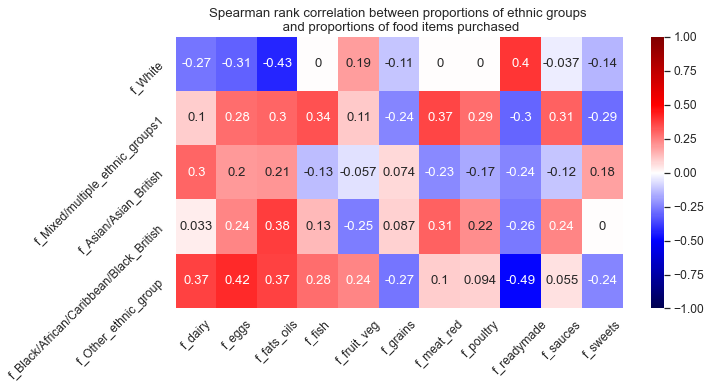

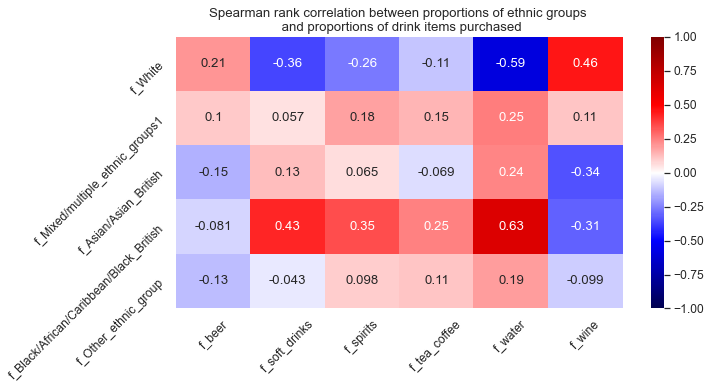

In [37]:
plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= 0.05] = 0
plot_df

ethnicity_list = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['f_White',
                    'f_Mixed/multiple_ethnic_groups1',
                    'f_Asian/Asian_British',
                    'f_Black/African/Caribbean/Black_British',
                    'f_Other_ethnic_group']    
    
food_list = ['f_dairy',
             'f_eggs',
             'f_fats_oils',
             'f_fish',
             'f_fruit_veg',
             'f_grains',
             'f_meat_red',
             'f_poultry',
             'f_readymade',
             'f_sauces',
             'f_sweets']

drink_list = ['f_beer',
              'f_soft_drinks',
              'f_spirits',
              'f_tea_coffee',
              'f_water',
              'f_wine']

plt.figure(figsize=(10,5))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic groups \n and proportions of food items purchased')
ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)


plt.figure(figsize=(10,5))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic groups \n and proportions of drink items purchased')
ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)
plt.show()

## Linear regression

From our intuition, we selected features that we initially thought impacted the food purchase diversity the most.

In [44]:
eco_activ = full_df['Economic_Activity;Employment_Rate;2011']
eco_activ_stand = (eco_activ - np.mean(eco_activ))/np.std(eco_activ)

income = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
income_stand = (income - np.mean(income))/np.std(income)

age = full_df['avg_age']
age_stand = (age - np.mean(age))/np.std(age)

h_items = full_df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']
h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

In [45]:
lin_reg_df = pd.DataFrame()
lin_reg_df['eco'] = eco_activ_stand
lin_reg_df['income'] = income_stand
lin_reg_df['age'] = age_stand
lin_reg_df['h_items'] = h_items_stand
lin_reg_df['h_ethnicity'] = h_ethnicity_stand
lin_reg_df.head()

,eco,income,age,h_items,h_ethnicity
LSOA11NM,,,,,
City of London 001A,1.465458,1.971130,3.214820,-1.382446,-1.378456
City of London 001B,1.453738,1.867475,2.976434,-1.104701,-1.896204
City of London 001C,0.563031,-0.119432,3.232598,0.359911,-0.798115
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.927231
Barking and Dagenham 016A,-0.444873,0.295365,-1.102792,-0.245228,0.639302


### Predicting food purchase diversity using linear regression ##

First, we will try to keep only the ethnic entropy (`h_ethnicity`) to try to explain the food consumption entropy (`h_items`).

In [49]:
train_df, test_df = train_test_split(lin_reg_df, test_size=0.3, random_state=42)

feature_cols = ['h_ethnicity']

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = train_df['h_items']
y_test = test_df['h_items']

lin_reg = LinearRegression()  # create the model
lin_reg.fit(X_train, y_train)  # train
y_pred_test = lin_reg.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print('The ethnic entropy explains {0:.2f} % of the variance of the food consumption entropy.'
      .format(r2_test*100))

The ethnic entropy explains 12.07 % of the variance of the food consumption entropy.



We will now try to explain the variance in the food consumption entropy (`h_items`) with the following features of each LSOA:
- The ethnic entropy: `h_ethnicity`
- The employment rate: `eco`
- The average age: `age`
- The average income per household: `income`


In [50]:
feature_cols = ['eco', 'income', 'age', 'h_ethnicity']

# Linear regression with random split
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]
y_train = train_df['h_items']
y_test = test_df['h_items']

lin_reg = LinearRegression()  # create the model
lin_reg.fit(X_train, y_train)  # train
y_pred_test = lin_reg.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)

print('The feature columns used here explain {0:.2f} % of the variance of the food consumption entropy.'
      .format(r2_test*100))

The feature columns used here explain 19.30 % of the variance of the food consumption entropy.


When adding the employment rate, the median household income and the average age of the LSOA's population in the predicting factors, $R^2$ only rises from 12.9 to 19.9 %. This seems to suggest that the ethnic entropy has a non-negligible effect on the food category entropy.

We will now use the statsmodels module, and summarize the results to see the contribution and significance of each term. 

In [53]:
formula = 'h_items ~ h_ethnicity + eco + age + income'

mod = smf.ols(formula=formula, data=lin_reg_df)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     268.4
Date:                Sun, 13 Dec 2020   Prob (F-statistic):          1.30e-208
Time:                        17:57:12   Log-Likelihood:                -6372.5
No. Observations:                4833   AIC:                         1.275e+04
Df Residuals:                    4828   BIC:                         1.279e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.323e-15      0.013   1.02e-13      

From these results, it looks like all four predictive factors have a significant effect on the food category entropy. They suggest the following conclusions:
- LSOA with more ethnic diversity tend to have a larger food consumption diversity
- LSOA with a higher employment rate tend to have a larger food consumption diversity
- LSOA with a higher average age tend to have a lower food consumption diversity
- LSOA with a larger median income per household tend to have a lower food consumption diversity

As the features are standardized, the magnitude of their coefficients can be directly compared. This suggests that `income` impacts `h_items` the most, followed by `h_ethnicity`, `eco` and finally `age`. Even though it seems that ethnic diversity has an effect on food consumption diversity in an LSOA, we still need to be careful with the conclusions we might take here. Indeed, we could be in a situation where for example the `income` feature is a confounder and therefore it influences both `h_items` and `h_ethnicity`. We could therefore see an effect of `h_ethnicity` on `h_items`, even though it is actually `income` which impacts both indirectly. In this case, the effect of `h_ethnicity` on `h_items` could entirely be explained by `income`. To ensure that we are not in such a situation, we will use the notion of matching. We will first create a binary feature from `h_ethnicity` to divide the dataset in two groups. We will then perform a matching between these two groups, using the concept of propensity score. This will allow us to compare similar sets of samples and to get more insight on the effect of the ethnic diversity on the food consumption diversity.

Let us now select the most significant features of the full dataset from a statistical viewpoint, to reduce the dimensionality of the statistical analysis.

## Building a new dataframe to perform propensity score matching

In [16]:
def filter_for_analysis( df ):

    lone_rel_col = ['h_items_norm',
                    'Ethnic_Group;h_ethnicities_norm;2011',
                    'Country_of_Birth;ratio_United_Kingdom;2011',
                    'Household_Language;ratio_of_households_with_at_least_one_person_aged_16_or_over_with_English_as_a_main_language;2011']
    out_df = df.loc[:, lone_rel_col]
    
    out_df = pd.concat([ out_df, df.loc[:, 'representativeness_norm':'people_per_sq_km' ] ], axis=1)
    out_df = pd.concat([ out_df, df.loc[:, 'Households;All_households;2011':'Household_Composition;ratio_Other_multi_person_household;2011'] ], axis=1)
    out_df = pd.concat([ out_df, df.loc[:, 'Religion;Christian_(ratio);2011': ] ], axis=1)
    
    # found out the columns are not all numeric
    for col in out_df.columns:
        out_df[col] = pd.to_numeric(out_df[col])
    
    out_df.reset_index(inplace=True)
    out_df.drop(['LSOA11NM'], axis=1, inplace=True)
    out_df.dropna(axis=1, inplace=True)
    
    return out_df
    
filtered_df = filter_for_analysis(full_df)

### New entropy features

In [17]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_activ_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                         'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                         'Health;Day-to-day_activities_not_limited_(ratio);2011']

health_state_col_list = ['Health;Very_good_or_Good_health_(ratio);2011',
                         'Health;Fair_health_(ratio);2011',
                         'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']



h_household_compo, h_household_compo_norm = compute_entropies(filtered_df, household_compo_col_list)
h_religion, h_religion_norm = compute_entropies(filtered_df, religion_col_list)
h_tenure, h_tenure_norm = compute_entropies(filtered_df, tenure_col_list)
h_dwelling, h_dwelling_norm = compute_entropies(filtered_df, dwelling_col_list)
h_eco_activity, h_eco_activity_norm = compute_entropies(filtered_df, eco_activity_col_list)
h_qualif, h_qualif_norm = compute_entropies(filtered_df, qualif_col_list)
h_health_activ, h_health_activ_norm = compute_entropies(filtered_df, health_activ_col_list)
h_health_state, h_health_state_norm = compute_entropies(filtered_df, health_state_col_list)
h_car_avail, h_car_avail_norm = compute_entropies(filtered_df, car_avail_col_list)
h_age, h_age_norm = compute_entropies(filtered_df, age_col_list)


# insert the new columns
new_h_idx = filtered_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
filtered_df.insert(new_h_idx, 'h_household_compo', h_household_compo.tolist(), True)
filtered_df.insert(new_h_idx, 'h_religion', h_religion.tolist(), True)
filtered_df.insert(new_h_idx, 'h_tenure', h_tenure.tolist(), True)
filtered_df.insert(new_h_idx, 'h_dwelling', h_dwelling.tolist(), True)
filtered_df.insert(new_h_idx, 'h_eco_activity', h_eco_activity.tolist(), True)
filtered_df.insert(new_h_idx, 'h_qualif', h_qualif.tolist(), True)
filtered_df.insert(new_h_idx, 'h_health_activ', h_health_activ.tolist(), True)
filtered_df.insert(new_h_idx, 'h_health_state', h_health_state.tolist(), True)
filtered_df.insert(new_h_idx, 'h_car_avail', h_car_avail.tolist(), True)
filtered_df.insert(new_h_idx, 'h_age', h_age.tolist(), True)


filtered_df.shape

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 81)

We then standardize the dataset. Indeed, each feature is continuous and therefore we can directly perform it on the whole dataframe.

In [19]:
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

,h_items_norm,Ethnic_Group;h_ethnicities_norm;2011,h_age,h_car_avail,h_health_state,h_health_activ,h_qualif,h_eco_activity,h_dwelling,h_tenure,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
1923,0.238842,0.579811,0.137973,-0.465656,0.923340,0.775577,0.300337,0.806781,-0.127496,0.977858,...,-0.867242,0.466560,1.211553,0.570584,-0.067790,-0.752128,-0.628418,-0.587200,-0.749503,-0.739632
4031,-0.369018,-1.460434,0.876466,1.019758,-1.421973,-1.256740,0.544053,-1.324353,-0.731934,-1.747120,...,1.263857,-0.791790,-1.691542,-1.551880,0.044914,2.335208,1.132862,1.518456,-0.225336,-0.114534
2561,0.469625,0.823063,0.420173,0.504946,0.422461,0.226905,0.661602,-0.026435,0.141173,1.072645,...,-0.328344,0.151973,0.512660,-0.331328,0.683568,0.080641,0.069448,-0.263253,-0.825290,-0.863255
4505,0.608105,-1.195450,-0.562707,0.560996,-1.552964,-1.837499,-1.507300,-1.346805,0.486621,0.848471,...,1.533306,-1.656906,-1.100171,-0.450143,0.871408,0.121263,0.002984,0.141681,1.482750,1.359788
1046,0.848367,0.430206,0.625517,0.626976,0.826260,1.069841,0.423450,0.411486,0.577407,-0.421773,...,-0.793756,0.702501,0.781465,-0.266520,0.545819,-0.051384,0.368533,-0.020293,-1.011213,-1.010086


The goal is now to select the features that we want to use in the propensity score. The output feature (i.e. the one we want to predict in the end) is `h_items_norm`, and we will therefore compute the Spearman correlation between `h_items_norm` and all the other features.

In [20]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
correl_df['feature'] = std_df.columns[1:]

for i, col in enumerate(std_df.columns[1:]):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

,feature,correlation,p_value
0,Ethnic_Group;h_ethnicities_norm;2011,0.368818,1.285898e-155
1,h_age,-0.251449,1.385551e-70
2,h_car_avail,-0.304450,3.426849e-104
3,h_health_state,0.271326,2.553374e-82
4,h_health_activ,0.180005,1.771874e-36


Let us now discard the features for which the correlation with the output feature is not significant (i.e. their associated p-value > 0.05)

In [27]:
alpha = 0.05
filtered_correl_df = correl_df[ correl_df['p_value'] < alpha ]

filtered_correl_df.shape

(76, 3)

Let's now sort the features from the most to the least correlated to `h_items_norm`, using the absolute value of the correlation coefficent.

In [28]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(10)

,feature,correlation,abs_correlation,p_value
29,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
55,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
58,Economic_Activity;Unemployment_Rate;2011,0.417047,0.417047,9.912293e-203
41,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
43,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
52,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.402207,2.178904e-187
28,Household_Composition;ratio_Couple_household_w...,-0.378579,0.378579,1.593143e-164
10,h_household_compo,0.369545,0.369545,2.856378e-156
0,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.368818,1.285898e-155
78,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.352765,1.258317e-141


Let's keep the top N features for the General Propensity Score computation. In this case, to simplify the readability and level of interpretation of the following results, we will use N = 10.

In [29]:
main_features = sorted_correl_df.head(10)['feature'].tolist()
main_features.append('h_items_norm')
features_df = std_df[main_features]
features_df.columns

Index(['Household_Composition;ratio_Lone_parent_household;2011',
       'Economic_Activity;Economically_active:_Unemployed;2011',
       'Economic_Activity;Unemployment_Rate;2011',
       'Tenure;Owned_outright_(ratio);2011',
       'Tenure;Social_rented_(ratio);2011',
       'Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011',
       'Household_Composition;ratio_Couple_household_without_dependent_children;2011',
       'h_household_compo', 'Ethnic_Group;h_ethnicities_norm;2011',
       'Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)',
       'h_items_norm'],
      dtype='object')

It turns out that the treatment feature (the ethnic entropy) is among the features kept. If it was not the case, it would not be a problem. However, it is encouraging for the rest of the analysis.

In [34]:
#sns.pairplot(features_df);

With the following plot, we can get an idea of the correlation between the features that we want to use to compute the propensity score.

/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

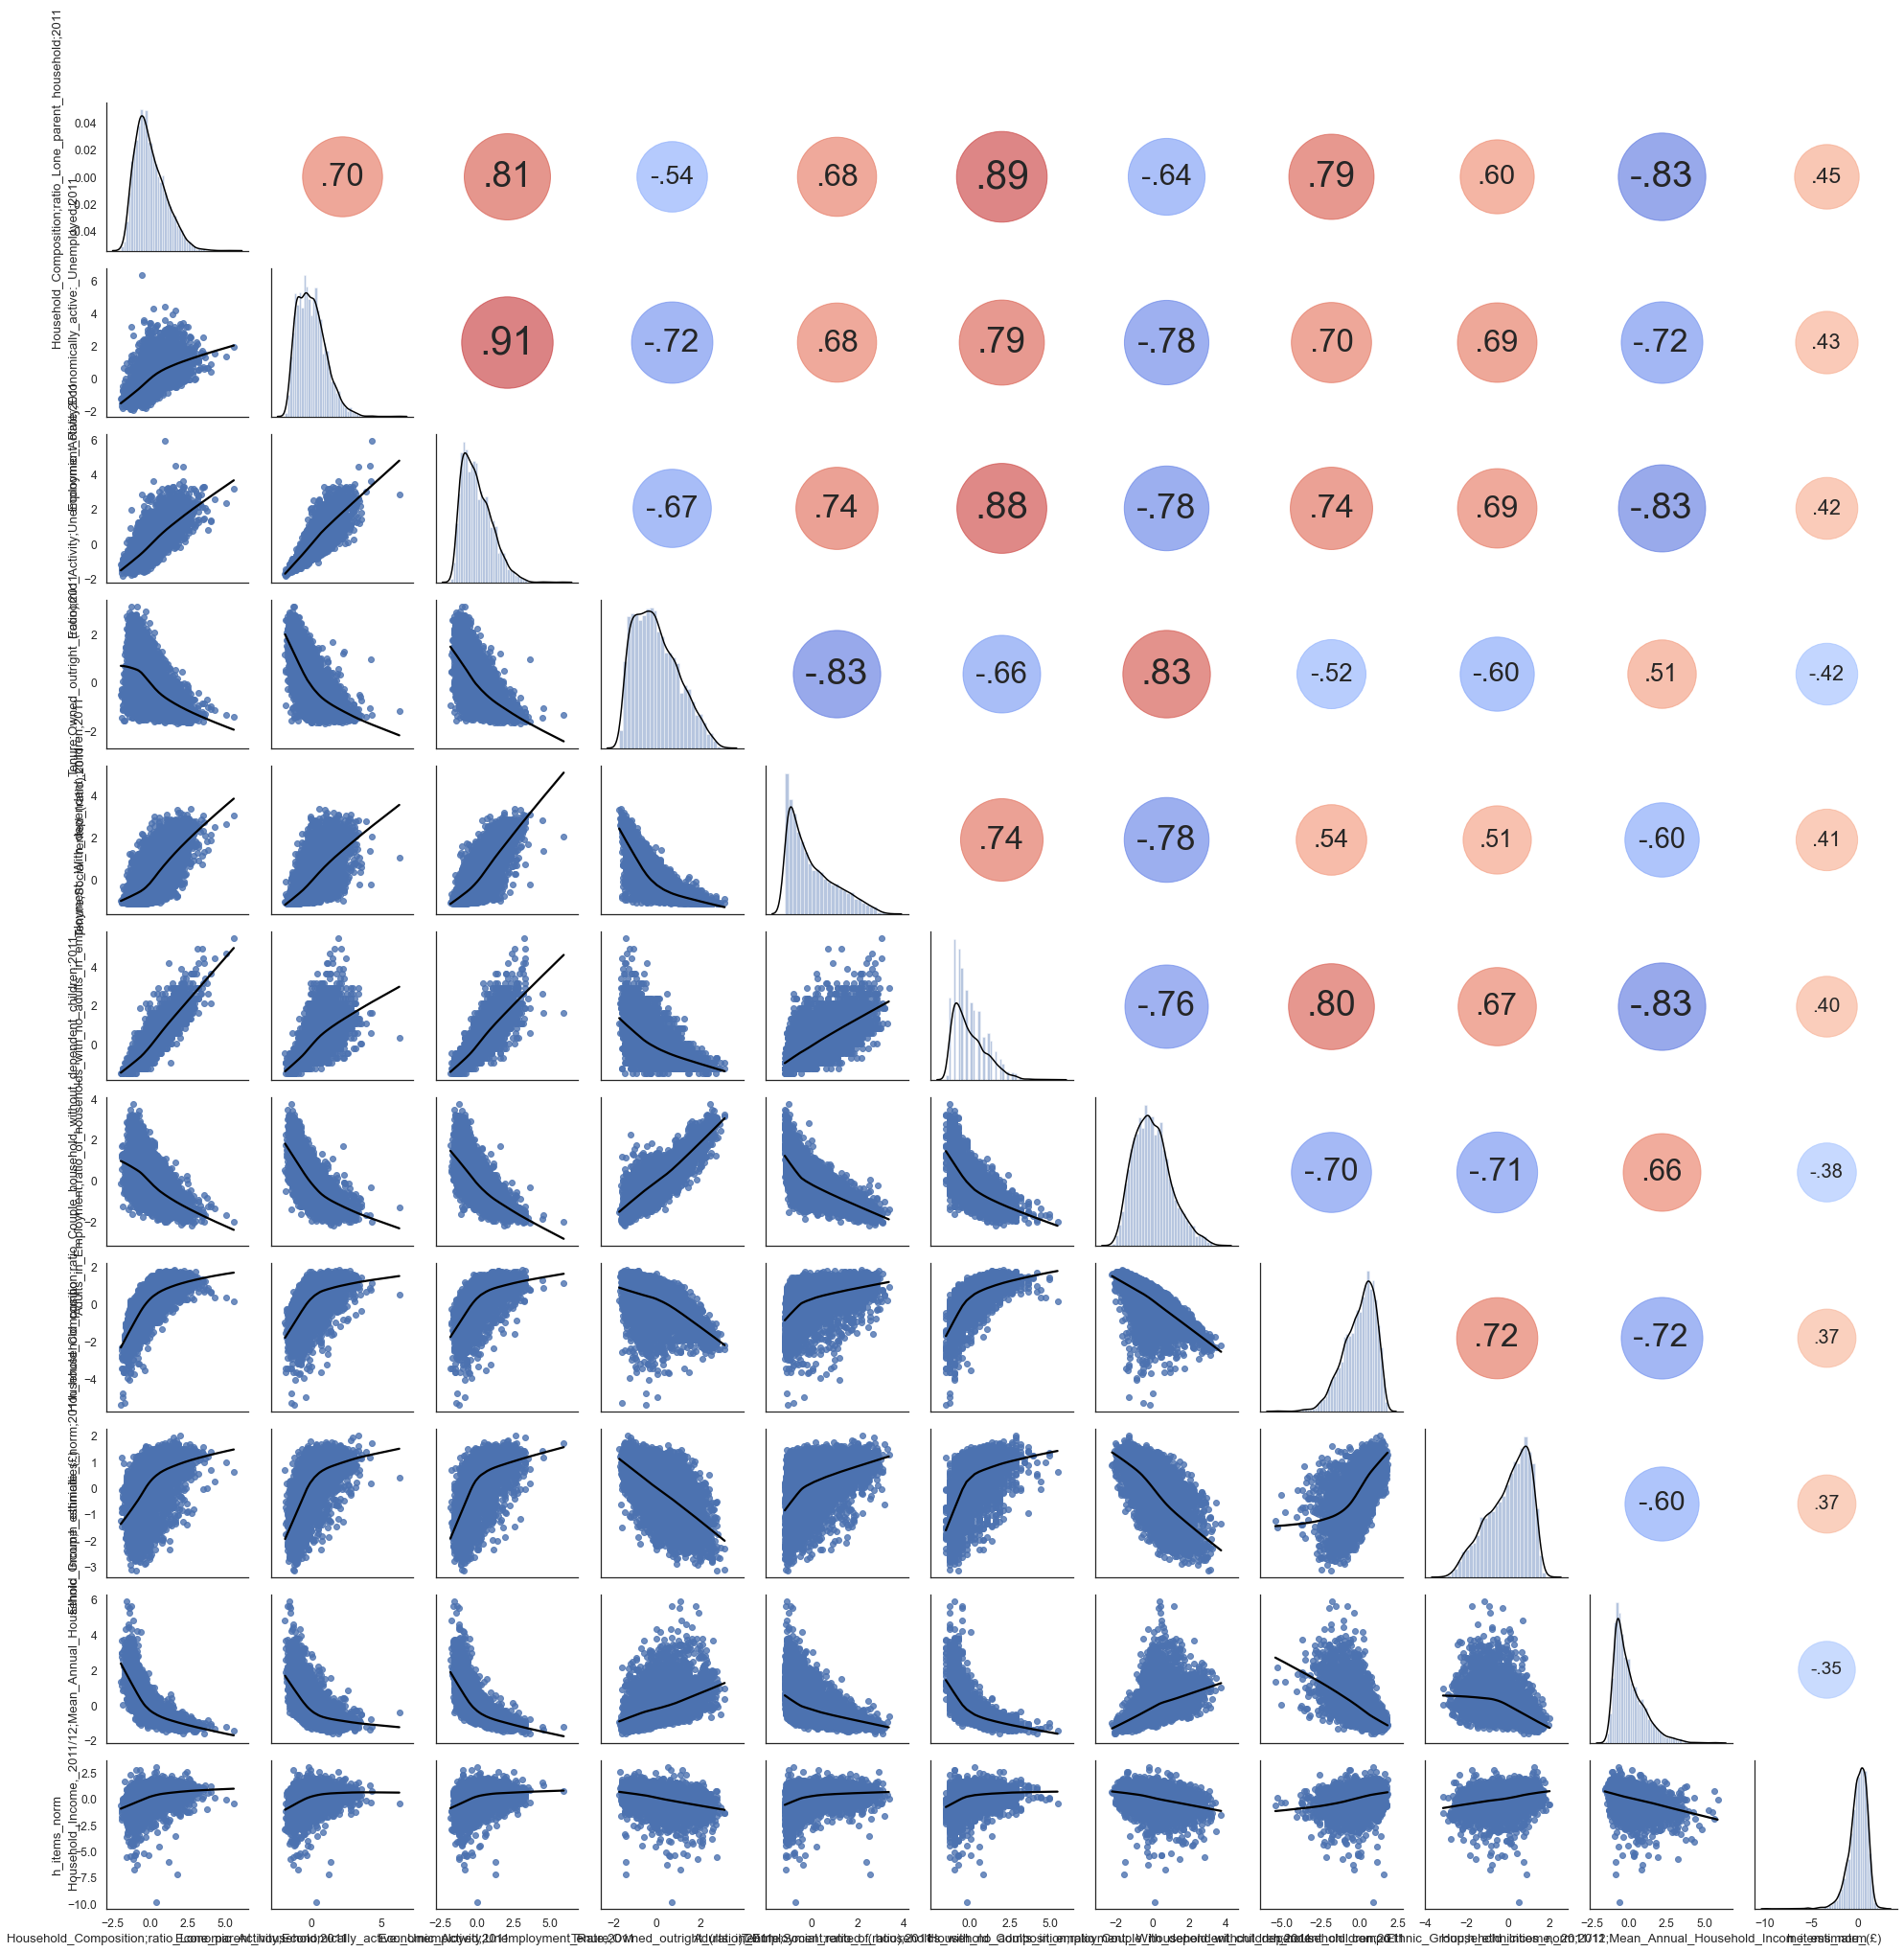

In [25]:
# source: https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.1)
#iris = sns.load_dataset('iris')
g = sns.PairGrid(features_df, aspect=1, diag_sharey=False);
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'});
g.map_diag(sns.distplot, kde_kws={'color': 'black'});
g.map_upper(corrdot);

As there are not two features with a very large correlation (> 0.95), we will keep all of them but the treatment feature for the propensity score computations.

We used an implementation of the Generalized Propensity Score (GPS) alogrithm. It outputs the effect of the treatment feature on the output feature.

In [30]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.2,
          upper_grid_constraint=0.8,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
#features.remove('h_ethnic')

treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'
features.remove(treat_feat)

# Fits the causal dose-response model.
gps.fit(T = features_df[treat_feat], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

gps_results = gps.calculate_CDRC(0.95)

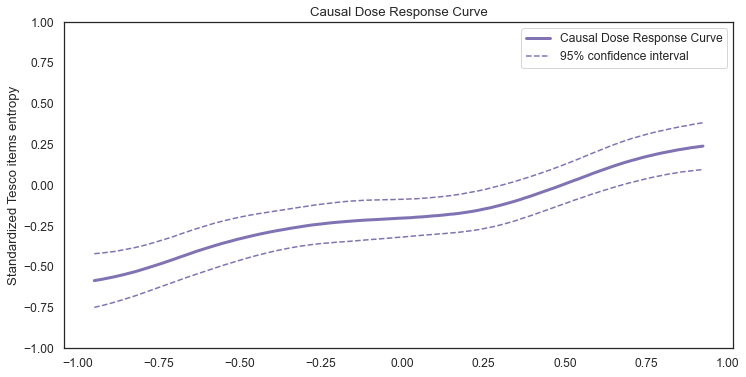

In [32]:
#### THE RESULTS CHANGE A LOT DEPENDING ON THE NUMBER OF SPLINES ###

fig, ax = plt.subplots(figsize=(12,6))
#plt.scatter(h_ethnicity_stand, stand_df['h_items'], s=1, zorder=1)
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
#plt.scatter(features_df['h_items_norm'],std_df['born_UK'], s=1);
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve') # estimated average dose response function ?
#plt.xlabel('Standardized born UK')
plt.ylabel('Standardized Tesco items entropy')
plt.show()

To measure the significance of the effect of ethnic entropy on food purchase entropy, we can use the following metric: the difference between the minimum value of the upper confidence interval (CI) and the maximum value of the lower CI. Indeed, if this difference is positive, it means that a horizontal line can be drawn inside the 95% confidence interval, which in turn means that the effect of the treatment is not significant (a horizontal line corresponds to  the treatment having no effect on the response of the items entropy).

In [33]:
treatment_effect_metric = (gps_results['Upper_CI'].min() - gps_results['Lower_CI'].max())
print(treatment_effect_metric)

-0.516


The more negative this metric is, the more significant is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe.